In [3]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

In [40]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, numpy.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature[numpy.newaxis, numpy.newaxis]  # to allow broadcast
        return numpy.nansum(self.g[..., numpy.newaxis] * 
                            numpy.exp(-self.chi[..., numpy.newaxis] / 
                                      constants.k_B / temp), axis=1)
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        pfunc = self.compute_partition_function(temperature)
        # Reshape arrays to allow broadcast
        temp = temperature[numpy.newaxis, numpy.newaxis]
        g_ratio = self.g[..., numpy.newaxis] / pfunc[:, numpy.newaxis]  # relative to total number of atoms in this stage
        chi = self.chi[..., numpy.newaxis]
        return g_ratio * numpy.exp(-chi / (constants.k_B * temp))
    
    def compute_ionisation(self, temperature, electron_pressure):
        """
        Computes ionisation fractions according to the Saha law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * temperature) / 
                      (constants.h ** 2)) ** (3 / 2)
        nstage = numpy.zeros_like(partition_function) / units.m ** 3
        nstage[0] = 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             numpy.exp(-self.chi_ion[r + 1, numpy.newaxis] / 
                                       (constants.k_B * temperature[numpy.newaxis])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage / numpy.nansum(nstage, axis=0)

    def compute_populations(self, temperature, electron_pressure):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        return (self.compute_excitation(temperature) * 
                self.compute_ionisation(temperature, electron_pressure)[:, numpy.newaxis])

    def plot_payne(self, temperature, electron_pressure):
        """
        Plots the Payne curves for the current atom.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:, 0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:, 1].T, 'r--')
        if n_levels > 2:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:, 2].T, 'k:')
        ax.set_yscale('log')
        ax.set_ylim(1e-4, 1.1)
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('Populations')

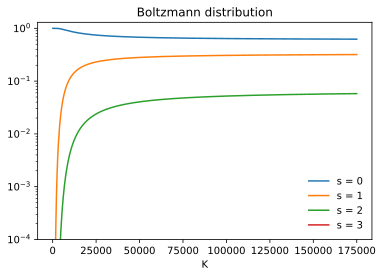

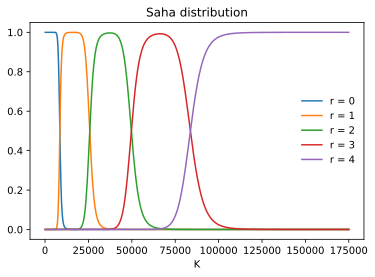

In [53]:
my_atom = Atom("C_atom.txt")
temp = numpy.linspace(100, 175000, 500) * units.K
e_press = 100 * units.Pa

boltz = my_atom.compute_excitation(temp)
saha = my_atom.compute_ionisation(temp, e_press)

plt.figure()
for i in range(4):
    name = "s = " + str(i)
    plt.semilogy(temp,boltz[0,i,:],label=name)
plt.ylim([1e-4,1.3])
plt.legend()
plt.title('Boltzmann distribution')

plt.figure()
for i in range(5):
    name = "r = " + str(i)
    plt.plot(temp, saha[i],label=name)
plt.title('Saha distribution')
plt.legend()